In [1]:
import datetime
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import gli_calc

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [4]:
%config InlineBackend.figure_format = "retina"

Data is stored on One Drive (contains PHI)

In [5]:
data_path = pd.read_csv(
    "/Users/mxposed/Documents/data_paths/ssc.csv",
    index_col=0
).value["clinical_data"]

In [6]:
out_path = os.path.join(data_path, "processed")
os.makedirs(out_path, exist_ok=True)

In [7]:
def redcap_column_names_from_dict(dictionary, prefix):
    return [f"{prefix}___{k}" for k in dictionary.keys()]

In [8]:
def parse_redcap_dict_field(data, dictionary, prefix, check_radio=True):
    columns = redcap_column_names_from_dict(dictionary, prefix)
    if check_radio:
        for col in columns:
            assert len({0, 1} - set(data[col].astype(int))) >= 0, f"Data for column {col} is out 0 or 1"
        assert np.all(data[columns].sum(axis=1).eq(1)), "For some rows there is more than 1 value"

    result = pd.Series(index=data.index, dtype=str)
    # relying on the .keys() iterator to be in the same order
    for i, key in enumerate(dictionary.keys()):
        result[data[columns[i]].eq(1)] = dictionary[key]
    return result

# Clinical data preprocessing

The goal of this notebook is to automatically integrate clinical data from 
1. Redcap
2. Yale
3. Single-cell table

and to preprocess and verify it

Load sample information

In [10]:
samples = pd.read_csv("../00all-samples.csv")

Load redcap data snapshot

In [11]:
redcap = pd.read_csv(os.path.join(data_path, "WntbetacateninInSScI_DATA_2023-02-17_1744.csv"))

Add publication IDs from GEO table

In [12]:
samples["Patient_id"] = samples.Sample

Strip `_followup` to get Redcap patient ids

In [13]:
samples.Patient_id = samples.Patient_id.str.replace("_followup$", "", regex=True)

In [14]:
paper_ids = pd.read_csv(os.path.join(
    os.path.dirname(os.path.dirname(data_path)),
    '04_bioRxiv',
    'GEO',
    'SSc_BAL_GEO_ID_MAPPING - ID mapping.csv'
))

In [15]:
paper_ids = paper_ids.merge(
    samples[['External Sample ID', 'Patient_id']],
    on='External Sample ID'
)

Take Duke separately

In [16]:
duke = samples.loc[samples.Study.eq('Duke')].copy()

Take only our samples

In [17]:
samples = samples.loc[samples.Study.eq("this"), :].copy()

Number of unique patients among our samples

In [18]:
samples.Patient_id.nunique()

14

Number of unique patients with information in Redcap

In [19]:
redcap.study_code[redcap.study_code.isin(samples.Patient_id)].nunique()

13

Patient without information in Redcap

In [ ]:
samples.Patient_id[~samples.Patient_id.isin(redcap.study_code)]

Correct, this is the Yale patient

In [21]:
yale_pts = samples.Patient_id[~samples.Patient_id.isin(redcap.study_code)]

In [22]:
yale_data = pd.read_csv(
    os.path.join(data_path, 'Yale', 'PathogenicWntbetaCat-WntDataForNU_DATA_2023-04-24_1607.csv')
)

In [23]:
yale_data = yale_data.loc[yale_data.study_code.isin(yale_pts)].copy()

In [24]:
redcap = redcap.loc[redcap.study_code.isin(samples.Patient_id)].copy()

## What we want!

1. Table 1 information
    1. Patient information
        * age (at bronch)
        * sex
        * race/ethnicity
        * smoking status
        * height
        * BMI
    2. Disease information
        * SSc subtype
        * Raynauld first symptom
        * non-Raynauld first symptom
        * MRSS
        * autoantibodies
        * ILD status
        * digital ulcers
        * hypertension status
    3. Clinical measurements
        * CRP
        * FVC
        * DLCO
        * FEV1
        * Monocyte count
        * 6MWD
        * RVSP
    4. Medications
        * prednisone
        * mycophenolate mofetil
        * ofev
        * actemra
        * rituximab
2. Timeline dates
    * non-Raynauld onset
    * Raynauld onset
    * PFT date
    * Bronch date
    * ILD diagnosis date
    * HRCT date
    * MRSS date
    * 6MWD date
    * TTE date (for RVSP)
    * Blood date (for monocytes)
3. Clinical correlation data
    * Table 1 +
    * 6MWD
    * TTE
    * Blood
    * HRCT scoring (from Hatice)

In [25]:
base_columns = ["study_code", "redcap_event_name", "redcap_repeat_instance"]

In [26]:
yale_base_columns = ["study_code", "redcap_event_name"]

### 1. Patient info

In [27]:
pt_info_columns = """
year_of_birth
sex
race
height
bmi
smoker
smoker_packyrs
""".strip().split("\n")

In [28]:
pt_info = redcap[base_columns + pt_info_columns].copy()

In [29]:
pt_info = pt_info.loc[~pt_info.year_of_birth.isna()]

In [30]:
pt_info.drop(columns=["redcap_event_name", "redcap_repeat_instance"], inplace=True)

In [31]:
pt_info.sex = pt_info.sex.map({1: "Male", 2: "Female"})

In [32]:
pt_info.race = pt_info.race.map({
    1: "Caucasian",
    2: "African American",
    3: "Asian",
    4: "American Indian or Alaska Native",
    5: "Hawaiian/Pacific Islander",
    6: "Hispanic or Latino",
})

In [33]:
pt_info.smoker = pt_info.smoker.astype(bool)

In [34]:
pt_info.year_of_birth = pt_info.year_of_birth.astype(int)

In [35]:
pt_info.shape

(13, 8)

In [36]:
yale_pt_info_columns = """
pt_form_dob
pt_form_gender
ssc_screen_q6
ssc_screen_q10
smoker
smoker_packyrs
""".strip().split("\n")

In [37]:
YALE_RACE = {
    1: "American Indian or Alaska Native",
    2: "Asian",
    3: "Black or African American",
    4: "Hispanic or Latino",
    5: "Native Hawaiian or Other Pacific Islander",
    6: "White",
    9: "Decline to Answer",
}
yale_pt_info_columns += redcap_column_names_from_dict(YALE_RACE, "pt_form_race")

In [38]:
yale_pt_info = yale_data[yale_base_columns + yale_pt_info_columns].copy()

In [39]:
yale_pt_info = yale_pt_info.loc[~yale_pt_info.pt_form_dob.isna()].copy()

In [40]:
yale_pt_info.pt_form_dob = pd.to_datetime(yale_pt_info.pt_form_dob)

In [41]:
def correct_year_after_2020(dt):
    if dt.year >= 2020:
        dt = datetime.date(year=dt.year - 100, month=dt.month, day=dt.day)
    return dt

yale_pt_info.pt_form_dob = pd.to_datetime(yale_pt_info.pt_form_dob.apply(correct_year_after_2020))

In [42]:
yale_pt_info["year_of_birth"] = yale_pt_info.pt_form_dob.dt.year

In [43]:
yale_pt_info["sex"] = yale_pt_info.pt_form_gender.map({1: "Male", 2: "Female"})

In [44]:
yale_pt_info["race"] = parse_redcap_dict_field(yale_pt_info, YALE_RACE, "pt_form_race")

Normalize Race to Northwestern definitions.

In [45]:
yale_pt_info.race = yale_pt_info.race.replace({
    "White": "Caucasian",
    "Black or African American": "African American",
    "Native Hawaiian or Other Pacific Islander": "Hawaiian/Pacific Islander"
})

In [46]:
yale_pt_info["height"] = yale_pt_info.ssc_screen_q6

In [47]:
yale_pt_info["bmi"] = yale_pt_info.ssc_screen_q10

In [48]:
yale_pt_info.smoker = yale_pt_info.smoker.astype(bool)

In [49]:
duke_pt = duke[['Sample', 'Age', 'Sex', 'Race', 'BMI', 'Smoking status']].copy()

In [50]:
duke_pt.rename(columns={
    'Sample': 'study_code',
    'Age': 'age',
    'Sex': 'sex',
    'Race': 'race',
    'BMI': 'bmi',
    'Smoking status': 'smoker',
}, inplace=True)

In [51]:
duke_pt.sex.replace({'male': 'Male', 'female': 'Female'}, inplace=True)

In [52]:
duke_pt.smoker.replace({'never': False}, inplace=True)

In [53]:
duke_pt.race.replace({
    'White': 'Caucasian',
    'Hispanic': 'Hispanic or Latino'
}, inplace=True)

In [54]:
pt_info = pd.concat([pt_info, yale_pt_info, duke_pt])[
    pt_info.columns.tolist() + ['age']
].reset_index(drop=True)

In [55]:
pt_info.height *= 2.54

In [56]:
patient_paper_ids = paper_ids.drop_duplicates(subset=['Patient_id']).copy()
patient_paper_ids['Publication ID'] = patient_paper_ids['Publication ID'].str.replace(r'-\d+$', '', regex=True)

In [57]:
pt_info = pt_info.merge(
    patient_paper_ids[['Patient_id', 'Publication ID']].rename(columns={'Publication ID': 'paper_id'}),
    left_on='study_code',
    right_on='Patient_id',
    how='left'
)

In [64]:
pt_info.to_csv(os.path.join(out_path, "01_pt_info.csv"))

### 2. Disease info

In [58]:
disease_info_columns = """
disease
ssc_subtype
nonraynaud_sx
diagnosis_date
acr_ulc_pit
ab_ana
ab_ana_pattern1
ab_ana_pattern2
ab_scl70
ab_aca
ab_rnaiii
mrss_total
mrss
""".strip().split("\n")

In [59]:
disease_info = redcap[base_columns + disease_info_columns].copy()

In [60]:
disease_info = disease_info.loc[~disease_info.disease.isna()]

In [61]:
disease_info.drop(columns=["redcap_event_name", "redcap_repeat_instance"], inplace=True)

In [62]:
disease_info.disease = disease_info.disease.map({
    1: "control",
    2: "SSc",
    3: "COPD",
    4: "Sarcoidosis",
})

In [63]:
disease_info.ssc_subtype = disease_info.ssc_subtype.map({
    1: "SSS",
    2: "lcSSc",
    3: "dcSSc",
})

In [64]:
disease_info.nonraynaud_sx = disease_info.nonraynaud_sx.map({
    1: "anemia",
    2: "calcinosis",
    3: "diarrhea",
    4: "DOE",
    5: "dysphagia",
    6: "fingertip ulcers",
    7: "GERD",
    8: "hyperpigmentation",
    9: "joint pain",
    10: "puffy hands",
    11: "sicca syndrome",
    12: "skin thickening",
    13: "SOB",
    14: "swelling",
    15: "telangiectasias",
    16: "other",
})

In [65]:
disease_info.diagnosis_date = pd.to_datetime(disease_info.diagnosis_date)

In [66]:
disease_info.acr_ulc_pit = disease_info.acr_ulc_pit.map({
    0: "no digital ulcers or pitting scars",
    2: "digital tip ulcers",
    3: "fingertip pitting scars"
})

In [67]:
ab_map = {
    0: "Negative",
    1: "Positive",
    2: "Unknown",
}
disease_info.ab_ana = disease_info.ab_ana.map(ab_map)
disease_info.ab_scl70 = disease_info.ab_scl70.map(ab_map)
disease_info.ab_aca = disease_info.ab_aca.map(ab_map)
disease_info.ab_rnaiii = disease_info.ab_rnaiii.map(ab_map)

In [68]:
ab_pattern_map = {
    0: np.nan,
    1: "centromere",
    2: "speckled",
    3: "homogenous",
    4: "nucleolar",
    5: "other",
}
disease_info.ab_ana_pattern1 = disease_info.ab_ana_pattern1.map(ab_pattern_map)
disease_info.ab_ana_pattern2 = disease_info.ab_ana_pattern2.map(ab_pattern_map)

MRSS is in 2 columns, some values are in both, some in one or another  
Verify that values are equal between columns and then merge them

In [69]:
mrss_present = ~disease_info.mrss.isna() & ~disease_info.mrss_total.isna()
assert np.all(disease_info.mrss[mrss_present] == disease_info.mrss_total[mrss_present])
disease_info.loc[disease_info.mrss.isna(), "mrss"] = disease_info.mrss_total[disease_info.mrss.isna()]

In [70]:
disease_info.drop(columns=["mrss_total"], inplace=True)

In [71]:
disease_info.shape

(13, 13)

In [72]:
yale_disease_info = yale_data[yale_base_columns + disease_info_columns].copy()

In [73]:
yale_disease_info = yale_disease_info.loc[~yale_disease_info.disease.isna()]

In [74]:
yale_disease_info.disease = yale_disease_info.disease.map({
    1: "control",
    2: "SSc",
})

In [75]:
yale_disease_info.ssc_subtype = yale_disease_info.ssc_subtype.map({
    1: "lcSSc",
    2: "dcSSc",
    3: "SSS",
})

In [76]:
yale_disease_info.nonraynaud_sx = yale_disease_info.nonraynaud_sx.map({
    1: "anemia",
    2: "calcinosis",
    3: "diarrhea",
    4: "DOE",
    5: "dysphagia",
    6: "fingertip ulcers",
    7: "GERD",
    8: "hyperpigmentation",
    9: "joint pain",
    10: "puffy hands",
    11: "sicca syndrome",
    12: "skin thickening",
    13: "SOB",
    14: "swelling",
    15: "telangiectasias",
    16: "other",
})

In [77]:
yale_disease_info.diagnosis_date = pd.to_datetime(yale_disease_info.diagnosis_date)

In [78]:
yale_disease_info.acr_ulc_pit = yale_disease_info.acr_ulc_pit.map({
    0: "no digital ulcers or pitting scars",
    2: "digital tip ulcers",
    3: "fingertip pitting scars"
})

In [79]:
ab_map = {
    0: "Negative",
    1: "Positive",
    2: "Unknown",
}
yale_disease_info.ab_ana = yale_disease_info.ab_ana.map(ab_map)
yale_disease_info.ab_scl70 = yale_disease_info.ab_scl70.map(ab_map)
yale_disease_info.ab_aca = yale_disease_info.ab_aca.map(ab_map)
yale_disease_info.ab_rnaiii = yale_disease_info.ab_rnaiii.map(ab_map)

In [80]:
ab_pattern_map = {
    0: np.nan,
    1: "centromere",
    2: "speckled",
    3: "homogenous",
    4: "nucleolar",
    5: "dense fine speckled",
    6: "other"
}
yale_disease_info.ab_ana_pattern1 = yale_disease_info.ab_ana_pattern1.map(ab_pattern_map)
yale_disease_info.ab_ana_pattern2 = yale_disease_info.ab_ana_pattern2.map(ab_pattern_map)

MRSS is in 2 columns, some values are in both, some in one or another  
Verify that values are equal between columns and then merge them

In [81]:
mrss_present = ~yale_disease_info.mrss.isna() & ~yale_disease_info.mrss_total.isna()
assert np.all(yale_disease_info.mrss[mrss_present] == yale_disease_info.mrss_total[mrss_present])
yale_disease_info.loc[
    yale_disease_info.mrss.isna(),
    "mrss"
] = yale_disease_info.mrss_total[yale_disease_info.mrss.isna()]

In [82]:
disease_info = pd.concat(
    [disease_info, yale_disease_info]
)[disease_info.columns].reset_index(drop=True)

In [83]:
duke_disease = duke[['Sample']].rename(columns={'Sample': 'study_code'})

In [84]:
duke_disease['disease'] = 'control'

In [85]:
disease_info = pd.concat([disease_info, duke_disease])

In [86]:
additional_info = pd.read_excel(os.path.join(data_path, "pHTN_Data.xlsx")).rename(
    columns={'Sample': 'study_code'}
)

In [87]:
additional_info = additional_info[[
    "study_code", 'cough', 'dyspnea'
]]

In [88]:
disease_info = disease_info.merge(additional_info, on="study_code", how="left")

In [86]:
disease_info.to_csv(os.path.join(out_path, "02_disease_info.csv"))

### 3. Clinical info

Includes recalculating FVC, FEV1, TLC

In [89]:
clinical_info_columns = """
crp
crp_date
pft_ivc_meas
pft_fvc_meas
pft_fev1_meas
pft_tlc_meas
pft_fvc_pred
pft_fev1_pred
pft_dlco_meas
pft_dlco_pred
pft_tlc_pred
pft_date
monocyte_absolute
monocyte_percentage
monocyte_date
""".strip().split("\n")

In [90]:
clin_info = redcap[base_columns + clinical_info_columns].copy()

In [91]:
additional_info = pd.read_excel(os.path.join(data_path, "pHTN_Data.xlsx"))

In [92]:
additional_info = additional_info[[
    "Sample", "TTE_date", "RVSP", "6MWD_date", "6MWD_pct", "6MWD_act",
    'k_score_gg', 'k_score_fib'
]]

In [93]:
clin_info = clin_info.merge(additional_info, left_on="study_code", right_on="Sample", how="left")

In [94]:
clin_info.drop(columns=["Sample"], inplace=True)

In [95]:
ssc_patients = disease_info.study_code[disease_info.disease.eq("SSc")]

In [96]:
clin_info = clin_info.loc[clin_info.study_code.isin(ssc_patients)].copy()

Keep rows where CRP or PFT data is present

In [97]:
clin_info = clin_info.loc[
    ~clin_info.crp.isna() | ~clin_info.pft_fvc_pred.isna()
].copy()

In [98]:
clin_info.rename(columns={
    "RVSP": "echo_rvsp",
    "TTE_date": "tte_date",
    "6MWD_pct": "6mwd_pct",
    "6MWD_act": "6mwd_act",
    "6MWD_date": "6mwd_date"
}, inplace=True)

In [99]:
clin_info.echo_rvsp = (
    clin_info.echo_rvsp.astype(str).str.strip().str.replace(
        ".", "", regex=False
    ).replace("", np.nan).astype(float)
)

In [100]:
clin_info["6mwd_pct"] = (
    clin_info["6mwd_pct"].astype(str).str.strip().str.replace(".", "", regex=False).replace(
        "",
        np.nan
    ).astype(float)
)

In [101]:
clin_info["6mwd_act"] = (
    clin_info["6mwd_act"].astype(str).str.strip().str.replace(".", "", regex=False).replace(
        "",
        np.nan
    ).astype(float)
)

In [102]:
clin_info["6mwd_date"] = clin_info["6mwd_date"].astype(str).str.strip().replace(".", "")

In [103]:
yale_clinical_info_columns = """
crp
crp_date
pft_ivc_meas
pft_fvc_meas
pft_fev1_meas
pft_tlc_meas
pft_fvc_pred
pft_fev1_pred
pft_dlco_meas
pft_dlco_pred
pft_tlc_pred
pft_date
monocyte_absolute
monocyte_percentage
cbc_date
pro_form_echo_q9
pro_form_echo_q2
""".strip().split("\n")

In [104]:
yale_clin_info = yale_data[yale_base_columns + yale_clinical_info_columns].copy()

In [105]:
yale_clin_info = yale_clin_info.loc[yale_clin_info.study_code.isin(ssc_patients)].copy()

In [106]:
yale_clin_info = yale_clin_info.merge(
    additional_info,
    left_on="study_code",
    right_on="Sample",
    how="left"
)

In [107]:
yale_clin_info.drop(columns=["Sample", "RVSP"], inplace=True)

In [108]:
yale_clin_info.rename(columns={
    "pro_form_echo_q9": "echo_rvsp",
    "pro_form_echo_q2": "tte_date",
    "6MWD_pct": "6mwd_pct",
    "6MWD_act": "6mwd_act",
    "6MWD_date": "6mwd_date",
    "cbc_date": "monocyte_date"
}, inplace=True)

In [109]:
yale_clin_info.echo_rvsp = yale_clin_info.echo_rvsp.str.replace(
    "mmHg", "", regex=False
).str.strip().astype(float)

In [110]:
yale_clin_info["6mwd_pct"] = yale_clin_info["6mwd_pct"].astype(float)

In [111]:
yale_clin_info["6mwd_act"] = yale_clin_info["6mwd_act"].astype(float)

Keep rows where CRP or PFT data is present

In [112]:
yale_clin_info = yale_clin_info.loc[
    ~yale_clin_info.crp.isna() | ~yale_clin_info.pft_fvc_pred.isna()
].copy()

In [113]:
yale_clin_info.monocyte_percentage = yale_clin_info.monocyte_percentage.str.replace("%", "").astype(float)

In [114]:
clin_info = pd.concat(
    [clin_info, yale_clin_info]
)[clin_info.columns].reset_index(drop=True)

In [115]:
for col in ("crp_date", "pft_date", "monocyte_date", "tte_date", "6mwd_date"):
    clin_info[col] = pd.to_datetime(clin_info[col], format='mixed', infer_datetime_format=True)

In [116]:
clin_info['fev1_fvc'] = 100 * clin_info.pft_fev1_meas / clin_info.pft_fvc_meas

In [117]:
clin_info['dlco_ratio'] = clin_info.pft_ivc_meas / clin_info.pft_fvc_meas

Recalculate PFT with new GLI calculator

In [118]:
pft_calc = clin_info.merge(pt_info, on='study_code')

In [119]:
idx = pft_calc.year_of_birth.notna()
pft_calc.loc[idx, 'year_of_birth'] = pd.to_datetime(
    pft_calc.year_of_birth[idx].astype(int).astype(str) + '-01-01'
)
pft_calc['year_of_birth'] = pd.to_datetime(pft_calc.year_of_birth)

In [120]:
pft_calc.pft_date = pd.to_datetime(pft_calc.pft_date)

In [121]:
pft_calc['pft_age'] = (pft_calc.pft_date - pft_calc.year_of_birth).dt.days / 365

In [122]:
pft_calc['tlc_pred'] = gli_calc.tlc_percent_predicted(
    pft_calc.sex.str.lower(),
    pft_calc.pft_age,
    pft_calc.height,
    pft_calc.pft_tlc_meas
)

In [123]:
pft_calc['fev1_pred'] = gli_calc.fev1_percent_predicted(
    pft_calc.sex.str.lower(),
    pft_calc.pft_age,
    pft_calc.height,
    pft_calc.pft_fev1_meas
)

In [124]:
pft_calc['fvc_pred'] = gli_calc.fvc_percent_predicted(
    pft_calc.sex.str.lower(),
    pft_calc.pft_age,
    pft_calc.height,
    pft_calc.pft_fvc_meas
)

In [125]:
pft_calc['dlco_pred'] = gli_calc.dlco_percent_predicted(
    pft_calc.sex.str.lower(),
    pft_calc.pft_age,
    pft_calc.height,
    pft_calc.pft_dlco_meas
)

In [138]:
df = pft_calc.reset_index()[[
    'index', 'study_code', 'tlc_pred', 'pft_tlc_pred',
    'fev1_pred', 'pft_fev1_pred',
    'fvc_pred', 'pft_fvc_pred',
    'dlco_pred', 'pft_dlco_pred'
]]
df['index'] = df['index'].astype(str) + '_' + df.study_code
df = df.drop(columns='study_code').rename(columns={
    'tlc_pred': 'TLC new',
    'pft_tlc_pred': 'TLC old',
    'fev1_pred': 'FEV1 new',
    'pft_fev1_pred': 'FEV1 old',
    'fvc_pred': 'FVC new',
    'pft_fvc_pred': 'FVC old',
    'dlco_pred': 'DLCO new',
    'pft_dlco_pred': 'DLCO old'
}).melt(
    id_vars='index',
)

In [139]:
df['Patient_id'] = df['index'].str.split('_').str[1:].str.join('_')
df = df.merge(
    paper_ids[['Patient_id', 'Publication ID']].rename(columns={'Publication ID': 'paper_id'}),
    on='Patient_id',
    how='left'
)
df['index'] = df['index'].str.split('_').str[0] + '_' + df['paper_id']

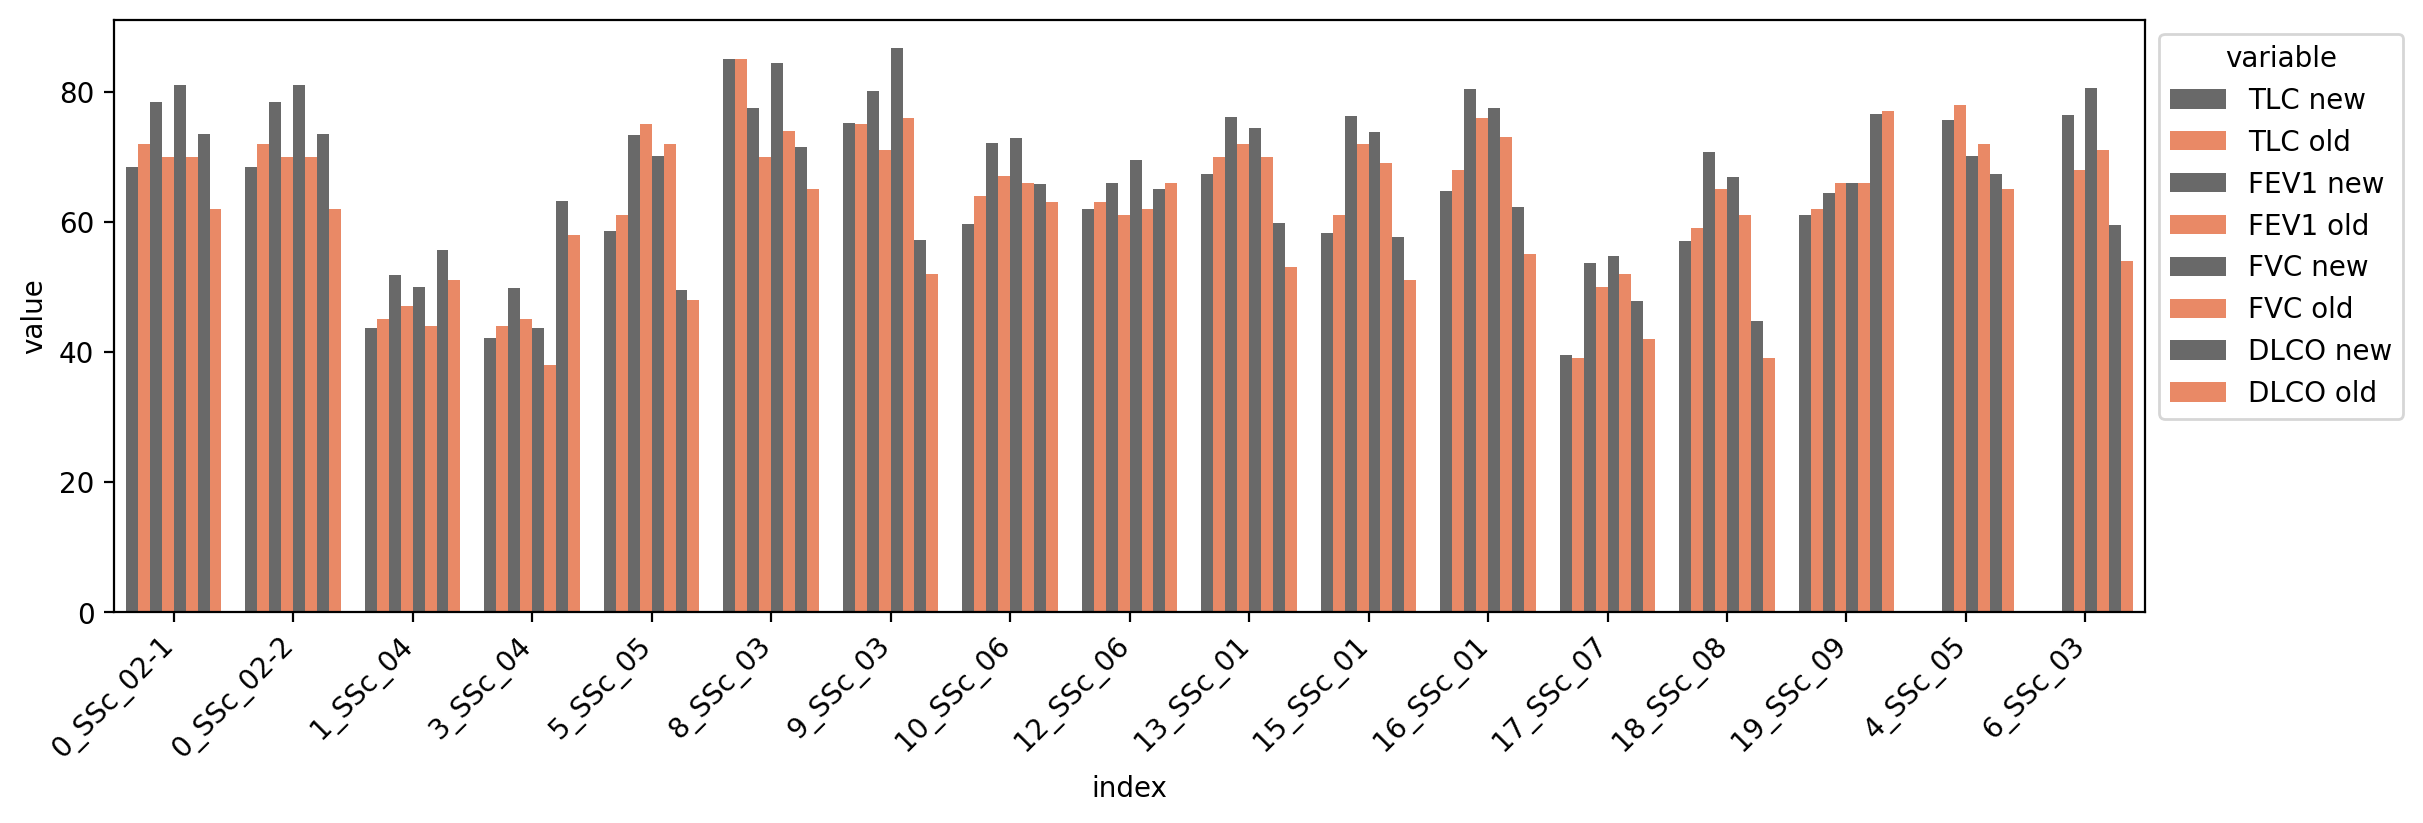

In [140]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
sns.barplot(
    data=df.dropna(),
    x='index',
    y='value',
    hue='variable',
    palette=['dimgray', 'coral'],
)
ax.legend_.set_bbox_to_anchor((1, 1))
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_rotation(45)
    t.set_ha('right')
    t.set_transform(t.get_transform() + trans)
fig.savefig('01_pft_calc.pdf')

In [141]:
clin_info['fvc_pred'] = pft_calc.fvc_pred
clin_info['fev1_pred'] = pft_calc.fev1_pred
clin_info['tlc_pred'] = pft_calc.tlc_pred
clin_info['dlco_pred'] = pft_calc.dlco_pred

In [142]:
hrct_scoring_all = pd.read_csv(os.path.join(data_path, 'hrct_scoring_all.csv'))
hrct_scoring_all.study_code = hrct_scoring_all.study_code.str.strip()

In [143]:
hrct_scoring = hrct_scoring_all.groupby('study_code').agg({
    'ggo_score': 'mean',
    'fib_score': 'mean'
}).reset_index()

In [144]:
clin_info = clin_info.merge(hrct_scoring, on='study_code', how='left').drop(
    columns=['k_score_gg', 'k_score_fib']
).rename(columns={'ggo_score': 'k_score_ggo', 'fib_score': 'k_score_fib'})

### Now add bronched lobe Kazerooni for each patient

To get the bronched lobe, we need sample table

In [145]:
clin_info['Sample'] = clin_info.study_code.copy()
idx = clin_info.redcap_event_name.eq('follow_up_arm_1')
clin_info.loc[idx, 'Sample'] += '_followup'

In [146]:
samples.Sample.isin(clin_info.Sample).sum()

9

We're missing 1 followup sample, but it's ok, since this sample has the same location as the main one for this patient, and since we will be reporting just 1 HRCT per patient, and HRCT is closer to baseline sample

In [147]:
clin_info = clin_info.merge(samples[['Sample', 'Tissue location']], on='Sample', how='left')

In [148]:
clin_info.shape

(20, 33)

In [149]:
clin_info = clin_info.merge(
    hrct_scoring_all[['study_code', 'lobe', 'ggo_score', 'fib_score']],
    left_on=['study_code', 'Tissue location'],
    right_on=['study_code', 'lobe'],
    how='left'
).rename(columns={'ggo_score': 'lobe_ggo_score', 'fib_score': 'lobe_fib_score'}).drop(
    columns=['Sample', 'Tissue location', 'lobe']
)

In [143]:
clin_info.to_csv(os.path.join(out_path, "03_clin_info.csv"))

### 4. Medications

In [150]:
meds_columns = """
cv_med_mmf_v2
cv_med_pred_v2
pred_dose
cv_med_rtx_v2
""".strip().split("\n")

In [151]:
meds_info = redcap[base_columns + meds_columns].copy()

In [152]:
meds_info = meds_info.loc[~meds_info.cv_med_mmf_v2.isna()].copy()

In [153]:
meds_info.cv_med_mmf_v2 = meds_info.cv_med_mmf_v2.astype(bool)
meds_info.cv_med_pred_v2 = meds_info.cv_med_pred_v2.astype(bool)
meds_info.cv_med_rtx_v2 = meds_info.cv_med_rtx_v2.astype(bool)

Check that values at baseline and followup are all the same

In [154]:
def check_meds_baseline_followup(df):
    if df.shape[0] < 2:
        return
    for c in meds_columns:
        assert df[c].nunique() <= 1, f"column {c} has more than 1 value for {df.study_code}"

meds_info.groupby("study_code").apply(check_meds_baseline_followup)

""


In [155]:
meds_info = meds_info.loc[meds_info.redcap_event_name.eq("baseline_arm_1")].copy()

In [156]:
meds_info.drop(columns=["redcap_event_name", "redcap_repeat_instance"], inplace=True)

In [157]:
meds_info.shape

(8, 5)

In [158]:
yale_meds_columns = """
cv_med_mmf_v2
cv_med_pred_v2
pred_dose_freq
cv_med_rtx_v2
""".strip().split("\n")

In [159]:
yale_data.columns.str.contains('actemra').sum()

0

In [160]:
yale_meds_info = yale_data[yale_base_columns + yale_meds_columns].copy()

In [161]:
yale_meds_info = yale_meds_info.loc[~yale_meds_info.cv_med_mmf_v2.isna()].copy()

In [162]:
yale_meds_info.cv_med_mmf_v2 = yale_meds_info.cv_med_mmf_v2.astype(bool)
yale_meds_info.cv_med_pred_v2 = yale_meds_info.cv_med_pred_v2.astype(bool)
yale_meds_info.cv_med_rtx_v2 = yale_meds_info.cv_med_rtx_v2.astype(bool)

In [163]:
yale_meds_info.rename(columns={"pred_dose_freq": "pred_dose"}, inplace=True)

In [164]:
meds_info = pd.concat(
    [meds_info, yale_meds_info]
)[meds_info.columns].reset_index(drop=True)

In [142]:
meds_info.to_csv(os.path.join(out_path, "04_meds_info.csv"))

### 5. Timeline dates

Let's put this in a table of: patient, event, date

In [165]:
date_columns = """
ssc_raynaud_date
ssc_nonraynaud_date
mrss_date
diagnosis_date
crp_date
mmf_bronch_start_date
pft_date
hrct_date
bronch_date
monocyte_date
""".strip().split("\n")

In [166]:
date_info = redcap[base_columns + date_columns].copy()

In [167]:
yale_date_columns = """
ssc_raynaud_date
ssc_nonraynaud_date
mrss_date
diagnosis_date
crp_date
mmf_bronch_start_date
pft_date
hrct_date
pro_form_bronch_q3_7f420c
cbc_date
pro_form_echo_q2
""".strip().split("\n")

In [168]:
yale_date_info = yale_data[yale_base_columns + yale_date_columns].copy()

In [169]:
yale_date_info.rename(columns={
    "pro_form_bronch_q3_7f420c": "bronch_date",
    "cbc_date": "monocyte_date",
    "pro_form_echo_q2": "tte_date"
}, inplace=True)

In [170]:
idx = ~yale_date_info.ssc_raynaud_date.isna()
yale_date_info.loc[idx, "ssc_raynaud_date"] = (
    yale_date_info.ssc_raynaud_date[idx].astype(int).astype(str) + "-01-01"
)
idx = ~yale_date_info.ssc_nonraynaud_date.isna()
yale_date_info.loc[idx, "ssc_nonraynaud_date"] = (
    yale_date_info.ssc_nonraynaud_date[idx].astype(int).astype(str) + "-01-01"
)

In [171]:
date_info = pd.concat(
    [date_info, yale_date_info]
)[date_info.columns].reset_index(drop=True)

In [172]:
date_info = date_info.melt(
    id_vars=["study_code", "redcap_event_name", "redcap_repeat_instance"],
    var_name="event",
    value_name="date"
)

In [173]:
date_info = date_info.loc[~date_info.date.isna()].copy()

In [174]:
date_info.date = pd.to_datetime(date_info.date, format='mixed', infer_datetime_format=True)

Load dates manually sent by Anthony, which include ILD diagnosis date (year)

In [175]:
anthony_dates = pd.read_excel(os.path.join(data_path, "clin-dates_AJE_deintified.xlsx"), index_col=0)

In [176]:
anthony_dates = anthony_dates[[
    "Participant ID",
    "Event Name",
    "Date of bronchoscopy",
    "Date of PFT",
    "Date of ILD Diagnosis",
    "Date of HRCT",
]]

In [177]:
anthony_dates.rename(columns={
    "Participant ID": "study_code",
    "Event Name": "redcap_event_name",
    "Date of bronchoscopy": "bronch_date",
    "Date of PFT": "pft_date",
    "Date of ILD Diagnosis": "ild_diag_date",
    "Date of HRCT": "hrct_date"
}, inplace=True)

In [178]:
anthony_dates = anthony_dates.loc[anthony_dates.study_code.isin(ssc_patients)].copy()

In [179]:
anthony_dates = anthony_dates.melt(
    id_vars=["study_code", "redcap_event_name"],
    var_name="event",
    value_name="date"
)

In [180]:
anthony_dates.loc[anthony_dates.date.eq("."), "date"] = np.nan

In [181]:
anthony_dates = anthony_dates.loc[~anthony_dates.date.isna()].copy()

In [182]:
idx = anthony_dates.event.eq("ild_diag_date")
anthony_dates.loc[idx, "date"] = anthony_dates.date[idx].astype(int).astype(str) + "-01-01"

In [183]:
anthony_dates.date = pd.to_datetime(anthony_dates.date)

In [184]:
anthony_dates.redcap_event_name = anthony_dates.redcap_event_name.str.strip().map({
    "Baseline": "baseline_arm_1",
    "Follow up": "follow_up_arm_1",
    "Longitudinal Data": "longitudinal_data_arm_1",
})

Let's verify that all dates from Anthony are the same

In [185]:
anthony_dates.shape

(39, 4)

Manual inspection shows the same below

In [186]:
# anthony_dates.merge(
#     date_info,
#     on=["study_code", "redcap_event_name", "event"],
#     how="left"
# )

Let's add ILD diagnosis date

In [187]:
date_info = pd.concat([date_info, anthony_dates.loc[anthony_dates.event.eq("ild_diag_date")]])

In [188]:
additional_info = pd.read_excel(os.path.join(data_path, "pHTN_Data.xlsx"))

In [189]:
additional_info = additional_info[["Sample", "6MWD_date", "TTE_date"]]

In [190]:
additional_info.rename(columns={
    "Sample": "study_code",
    "6MWD_date": "6mwd_date",
    "TTE_date": "tte_date"
}, inplace=True)

In [191]:
additional_info = additional_info.melt(
    id_vars=["study_code"],
    var_name="event",
    value_name="date"
)

In [192]:
additional_info.date = pd.to_datetime(
    additional_info.date.fillna(".").astype(str).str.strip().replace(".", np.nan)
)

In [193]:
additional_info = additional_info.loc[~additional_info.date.isna()]

In [194]:
date_info = pd.concat([date_info, additional_info])

In [195]:
date_info = date_info.sort_values(["study_code", "date"])

In [174]:
date_info.to_csv(os.path.join(out_path, "05_date_info.csv"))

# Duke samples

In [196]:
duke_pft = pd.read_excel(os.path.join(data_path, '05APR2024 DUKE PFTs.xlsx')).dropna()

In [197]:
duke_pft['height'] = duke_pft['HT (in)'] * 2.54

In [198]:
duke_pft['fev1_pred'] = gli_calc.fev1_percent_predicted(
    duke_pft.Gender.str.lower(),
    duke_pft.Age,
    duke_pft.height,
    duke_pft['FEV1 (L)']
)

In [199]:
duke_pft['fvc_pred'] = gli_calc.fvc_percent_predicted(
    duke_pft.Gender.str.lower(),
    duke_pft.Age,
    duke_pft.height,
    duke_pft['FVC (L)']
)

In [200]:
df = duke_pft.reset_index()[[
    'ID',
    'fev1_pred', '% Pred',
    'fvc_pred', '% Pred.1'
]]
df = df.rename(columns={
    'fev1_pred': 'FEV1 new',
    '% Pred': 'FEV1 old',
    'fvc_pred': 'FVC new',
    '% Pred.1': 'FVC old'
}).melt(
    id_vars='ID',
)

In [205]:
df = df.merge(
    paper_ids[['Patient_id', 'Publication ID']].rename(columns={'Publication ID': 'paper_id'}),
    left_on='ID',
    right_on='Patient_id',
    how='left'
)

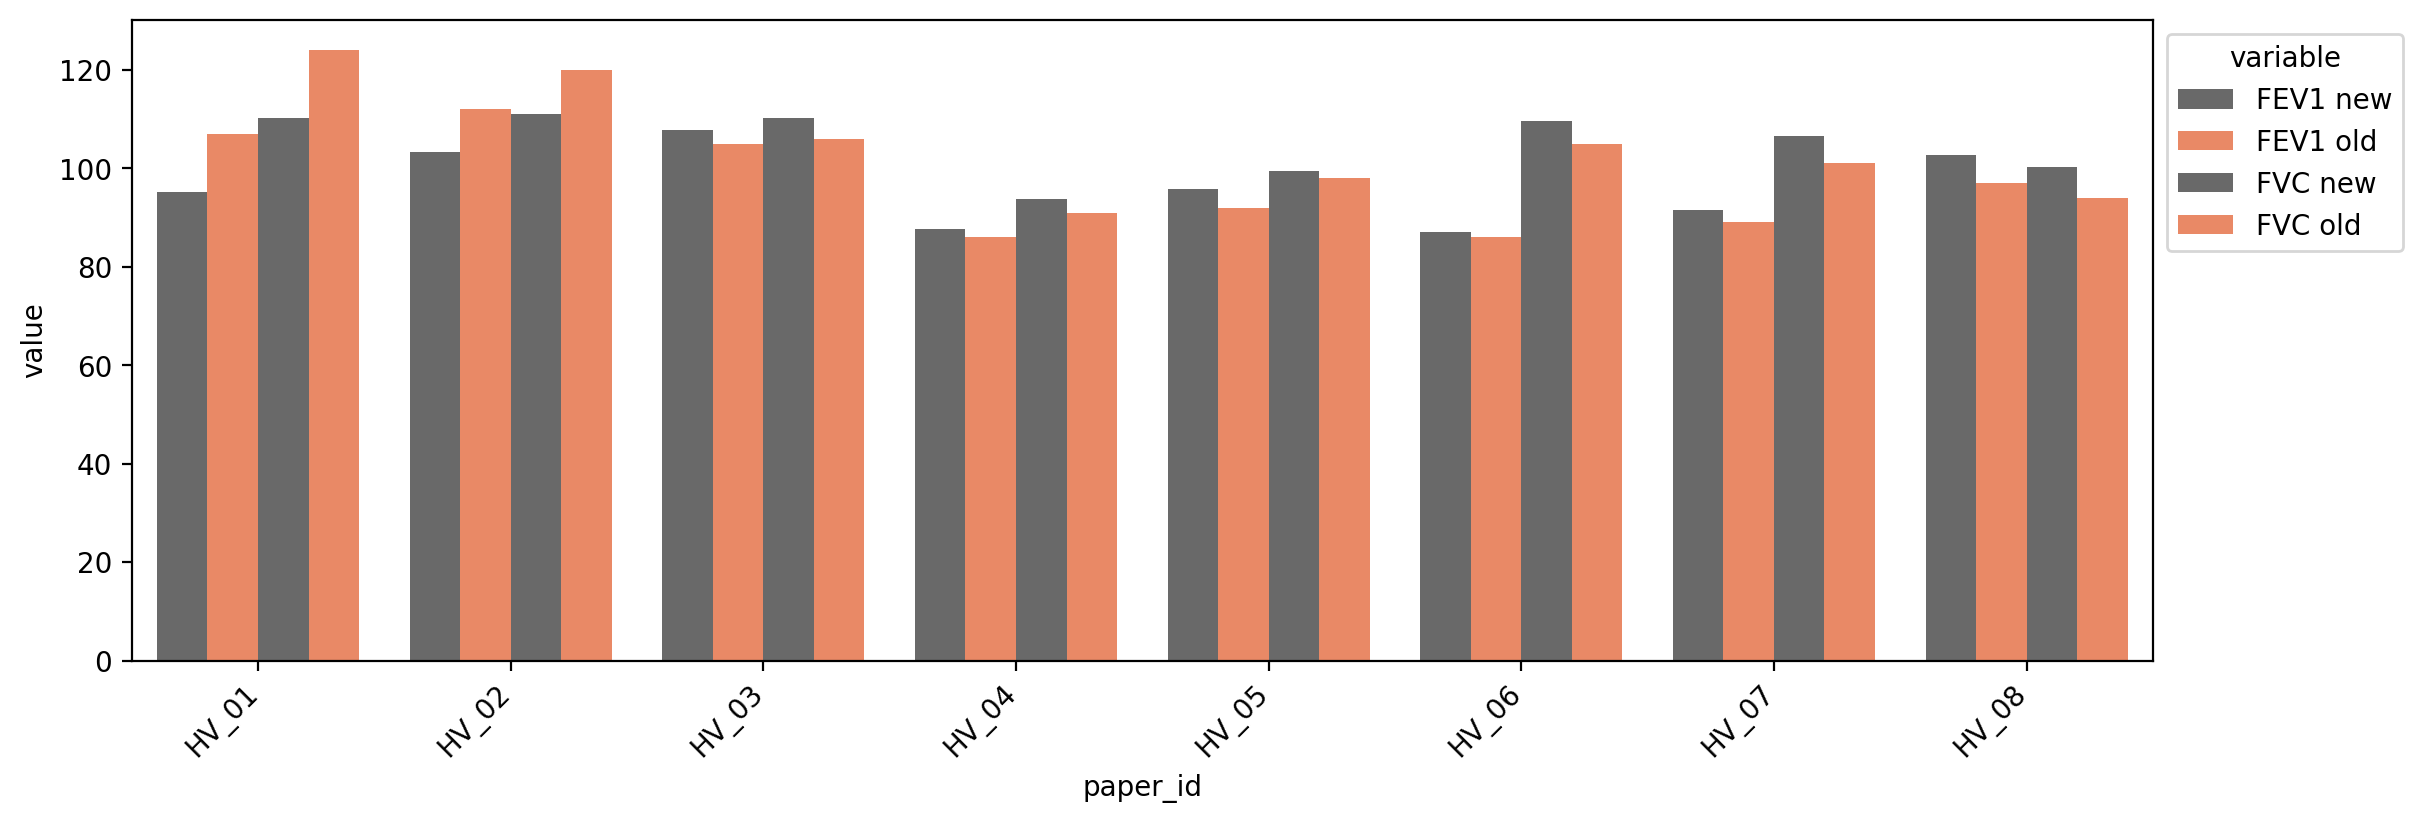

In [206]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
sns.barplot(
    data=df.dropna(),
    x='paper_id',
    y='value',
    hue='variable',
    palette=['dimgray', 'coral'],
)
ax.legend_.set_bbox_to_anchor((1, 1))
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_rotation(45)
    t.set_ha('right')
    t.set_transform(t.get_transform() + trans)

In [207]:
duke_pft = duke_pft.merge(duke, left_on='ID', right_on='Sample')[
    ['Sample', 'fvc_pred', 'fev1_pred']
]

In [182]:
duke_pft.to_csv(os.path.join(out_path, "06_duke_pft.csv"))